# Homework 6

## Imports

In [1]:
import os
import random
import re
import string
from transformers import AutoTokenizer
import joblib

from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import numpy as np
from cleanlab import Datalab
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Downloading and exploring the data

### Load dataset from hf

In [2]:
dataset = load_dataset("PolyAI/banking77", trust_remote_code=True)
df_raw = dataset["train"].to_pandas()
print(df_raw.head())

print(f"Number of classes: {dataset['train'].features['label'].num_classes}")
print(f"Number of training samples: {len(dataset['train'])}")

README.md: 0.00B [00:00, ?B/s]

banking77.py: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

                                                text  label
0                     I am still waiting on my card?     11
1  What can I do if my card still hasn't arrived ...     11
2  I have been waiting over a week. Is the card s...     11
3  Can I track my card while it is in the process...     11
4  How do I know if I will get my card, or if it ...     11
Number of classes: 77
Number of training samples: 10003


In [3]:
label_names = dataset["train"].features["label"].names

for i, name in enumerate(label_names):
    print(f"{i}: {name}")

0: activate_my_card
1: age_limit
2: apple_pay_or_google_pay
3: atm_support
4: automatic_top_up
5: balance_not_updated_after_bank_transfer
6: balance_not_updated_after_cheque_or_cash_deposit
7: beneficiary_not_allowed
8: cancel_transfer
9: card_about_to_expire
10: card_acceptance
11: card_arrival
12: card_delivery_estimate
13: card_linking
14: card_not_working
15: card_payment_fee_charged
16: card_payment_not_recognised
17: card_payment_wrong_exchange_rate
18: card_swallowed
19: cash_withdrawal_charge
20: cash_withdrawal_not_recognised
21: change_pin
22: compromised_card
23: contactless_not_working
24: country_support
25: declined_card_payment
26: declined_cash_withdrawal
27: declined_transfer
28: direct_debit_payment_not_recognised
29: disposable_card_limits
30: edit_personal_details
31: exchange_charge
32: exchange_rate
33: exchange_via_app
34: extra_charge_on_statement
35: failed_transfer
36: fiat_currency_support
37: get_disposable_virtual_card
38: get_physical_card
39: getting_spar

### Basic Data Exploration

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10003 non-null  object
 1   label   10003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [5]:
df_raw.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


In [6]:
df_raw.tail(10)

,text,label
9993,can I use it all over the world?,24
9994,Do you work in Greece?,24
9995,What countries do your accounts support?,24
9996,I live in the US and I would like to get a car...,24
9997,I just moved to the US how do I get a card?,24
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24
10002,Which countries are represented?,24


**Number of null values in columns**

In [7]:
print(f"Number of nulls in 'label': {df_raw['label'].isnull().sum()}")
print(f"Number of nulls in 'text': {df_raw['text'].isnull().sum()}")

Number of nulls in 'label': 0
Number of nulls in 'text': 0


**Common texts**

In [8]:
print(f"Unique texts count: {len(df_raw['text'].unique())}")
print(f"Dataset len: {len(df_raw)}")

Unique texts count: 10003
Dataset len: 10003


In [9]:
def uncase_and_without_spaces(text: str) -> str:
    return text.lower().strip()


print(f"Unique texts count: {len(df_raw['text'].apply(uncase_and_without_spaces).unique())}")
print(f"Dataset len: {len(df_raw)}")

Unique texts count: 9999
Dataset len: 10003


Almost all of texts are unique.

**Classes distribution**

In [10]:
labels_count = df_raw["label"].value_counts()
labels_count

label
15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: count, Length: 77, dtype: int64

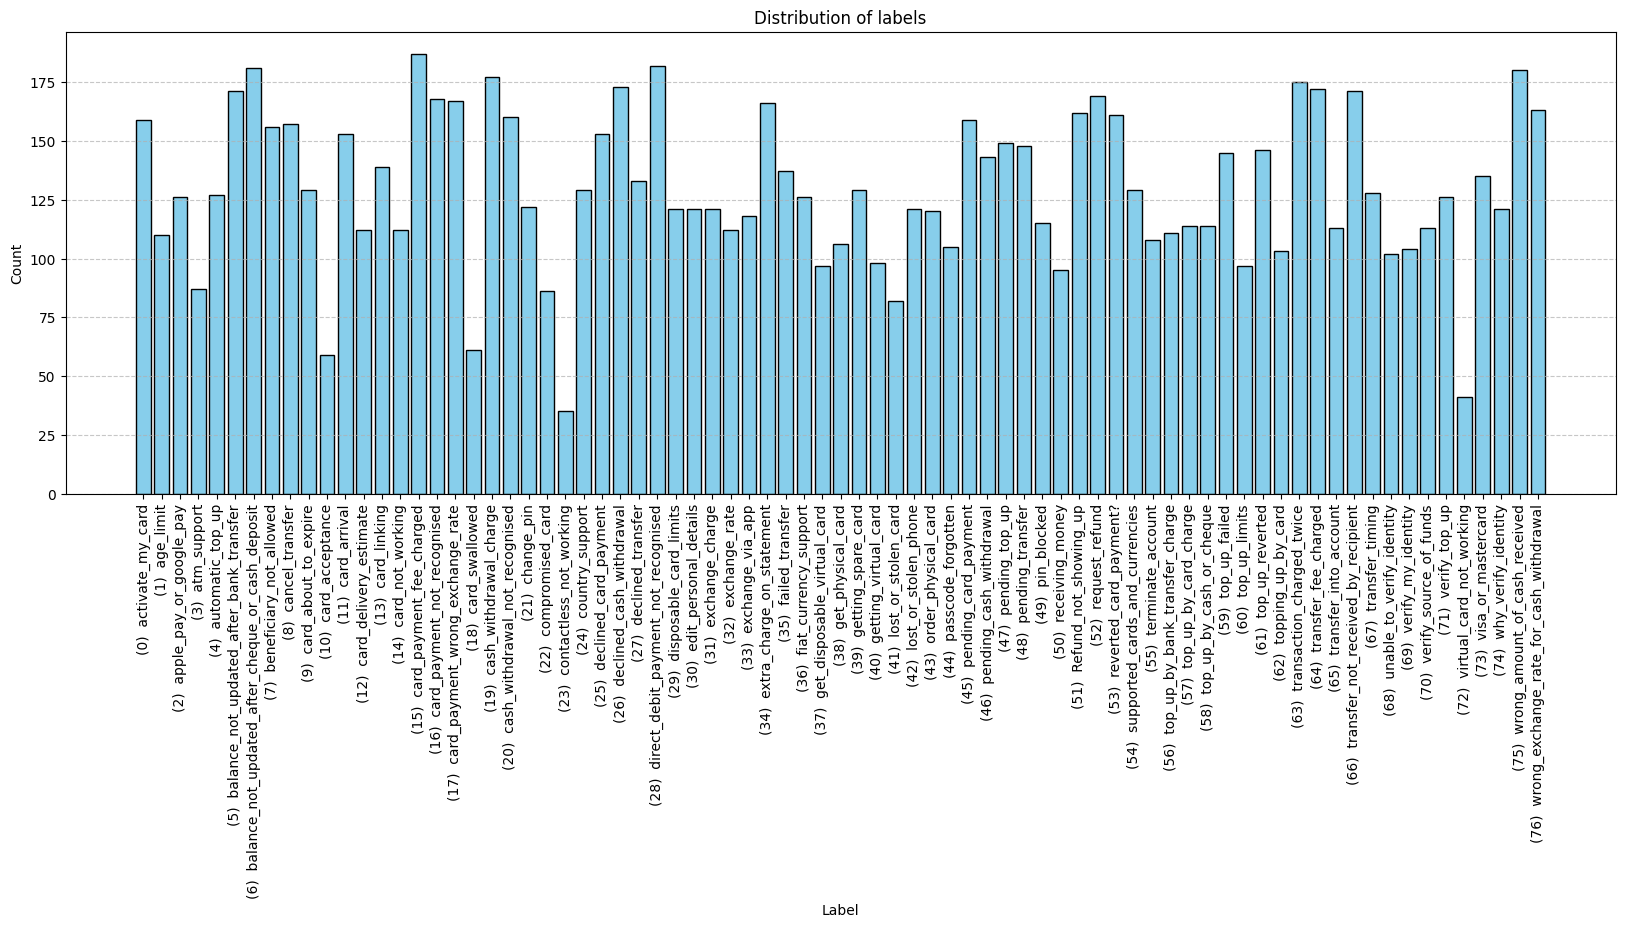

In [11]:
plt.figure(figsize=(20, 6))
plt.bar(labels_count.index, labels_count.values, color='skyblue', edgecolor='black')
plt.xticks(labels_count.index, [f"({i})  {label_names[i]}" for i in labels_count.index], rotation=90)
plt.title("Distribution of labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [12]:
labels_count_sorted = labels_count.sort_values()
labels_count_sorted.head(10)

label
23    35
72    41
10    59
18    61
41    82
22    86
3     87
50    95
60    97
37    97
Name: count, dtype: int64

Some of the labels are less popular in the dataset.

**text length distribution**

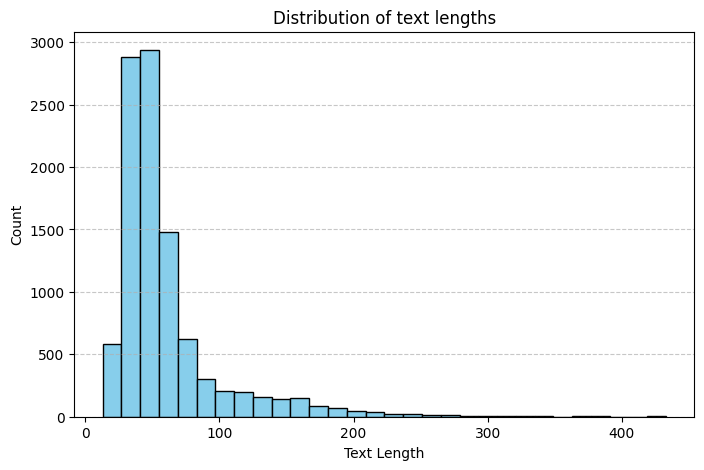

In [13]:
text_length = df_raw['text'].apply(len)

plt.figure(figsize=(8, 5))
plt.hist(text_length, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of text lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
short_texts = text_length[text_length < 100]
short_prc = (len(short_texts) / len(text_length)) * 100
print(f"Number of short texts (<100 chars): {len(short_texts)}. It is {short_prc:.2f}% of the dataset.")

Number of short texts (<100 chars): 8868. It is 88.65% of the dataset.


Majority of texts are short, with lengths less than 100 characters.

## 2. Cleanlab for data quality

### Model preparation

In [15]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
clf = LogisticRegressionCV(solver="lbfgs", max_iter=500, class_weight="balanced")


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    embeddings = embedding_model.encode(texts, convert_to_numpy=True)
    pred_probs = cross_val_predict(clf, embeddings, labels, cv=5, method="predict_proba")
    return embeddings, pred_probs

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
texts = df_raw["text"].values
labels = df_raw["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

### Datalab 

In [17]:
data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 632 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         150
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

There are a lot of issues that should be fixed in the dataset.

**Label issues examination and fixing**

In [18]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print("====" * 30)
    print(f"y_true: {label_names[y_true]} ({y_true})\ny_pred {label_names[y_pred]} ({y_pred})\ntext: {text}")
    print()

Top 10 label issues
y_true: topping_up_by_card (62)
y_pred top_up_reverted (61)
text: what happened to the money after i put in the wrong info and it got declined

y_true: card_arrival (11)
y_pred card_not_working (14)
text: WHAT IS THE SOLUTION OF THIS PROBLEM

y_true: disposable_card_limits (29)
y_pred getting_virtual_card (40)
text: i am not a premium customer but i want a virtual card, how do i get it

y_true: lost_or_stolen_card (41)
y_pred card_arrival (11)
text: Can you tell me the status of my new card?

y_true: declined_transfer (27)
y_pred beneficiary_not_allowed (7)
text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account

y_true: pending_top_up (47)
y_pred topping_up_by_card (62)
text: i put money on my card and i dont see it on the balance

y_true: card_not_working (14)
y_pred pin_blocked (49)
text: Can I use app to reset PIN attempts?

y_true: pin_blocked (49)
y_pred get_physical_card (38)
text: Where do I find PIN for my card?


Clearly, many of labels should be as model predicted them. Howerver, not all of them. Some of them are just unrelated or rubish in my opinion (eq.  2nd example above).

Score 0.981 is not that bad. So **I will leave it as it is**. Moreover there are less than 2% of data mislabeled.  However in the real life scenario it is easy to fix (but time consuming). Recipe for fixing:
- watch all 149 examples
- those that not make any sense - remove
- those that are clearly mislabelled - fix the label
- those that are ambiguous - leave as is

Then the model should perform much better.

**Near duplicates examination and fixing**

In [19]:
near_duplicate_issues = lab.get_issues("near_duplicate")
near_duplicate_issues = near_duplicate_issues[near_duplicate_issues["is_near_duplicate_issue"]]
near_duplicate_issues = near_duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in near_duplicate_issues.head(10).iterrows():
    text = texts[idx]
    label_true = labels[idx]
    label_true_name = label_names[label_true]

    neighbor_indices = row["near_duplicate_sets"][:3]

    print("====" * 30)
    print(f"Text: {text.strip()}")
    print(f"Label: {label_true_name} ({label_true})")
    print("Duplicates:")

    for ni in neighbor_indices:
        dup_text = texts[ni]
        dup_label = labels[ni]
        dup_label_name = label_names[dup_label]
        print(f" - [{dup_label_name} ({dup_label})] {dup_text.strip()}")

    print()


Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
Label: pin_blocked (49)
Duplicates:
 - [pin_blocked (49)] I put the wrong pin too many times and now it is blocked. Can you help me unblock it?

Text: I can't seem to be able to use my card
Label: card_not_working (14)
Duplicates:
 - [card_not_working (14)] I can't seem to be able to use my card

Text: Do I need to go to a physical bank to change my PIN?
Label: change_pin (21)
Duplicates:
 - [change_pin (21)] Do I need to go to a physical bank to change my PIN?

Text: I can't seem to be able to use my card
Label: card_not_working (14)
Duplicates:
 - [card_not_working (14)] I can't seem to be able to use my card

Text: Why do you keep declining my payment? I tried several times already with this card and it is just not working.
Label: declined_card_payment (25)
Duplicates:
 - [declined_card_payment (25)] Why do you keep declining my payment?I tried several times already with this card and it is j

These are really near duplicates. The difference is in top 10 case by "do" <-> "can" or even just sign "\n". Some of them look the same. To prevent that, duplicates that differ in only one char oshould be removed from the dataset.

Instances to remove:
- only one char differ - to remove missclick duplicates
- only case differ
- extra spaces


Duplicates that differ by one word or tense are acceptable.

In [20]:
def normalize_text(s):
    s = s.strip()
    s = s.replace("’", "'")
    s = ''.join(c for c in s if c not in string.punctuation)
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()


def differ_by_one_char(a, b):
    if abs(len(a) - len(b)) > 1:
        return False
    diff = 0
    for x, y in zip(a, b):
        if x != y:
            diff += 1
            if diff > 1:
                return False
    return True


df_raw["normalized_text"] = df_raw["text"].apply(normalize_text)
print(f"Unique normalized texts count: {len(df_raw['normalized_text'].unique())}")

Unique normalized texts count: 9993


In [21]:
to_remove = set()
normalized = [normalize_text(t) for t in texts]

for i in range(len(texts)):
    for j in range(i + 1, len(texts)):
        a = texts[i]
        b = texts[j]
        na = normalized[i]
        nb = normalized[j]

        if na == nb:
            to_remove.add(j)
            continue

        if differ_by_one_char(na, nb):
            to_remove.add(j)
            continue

print(f"Number of instances to remove: {len(to_remove)}")

Number of instances to remove: 29


In [22]:
df_deduplicated = df_raw.drop(index=list(to_remove)).reset_index(drop=True)

print(f"Original dataset size: {len(df_raw)}")
print(f"Deduplicated dataset size: {len(df_deduplicated)}")

Original dataset size: 10003
Deduplicated dataset size: 9974


In [23]:
df_deduplicated.head(10)

,text,label,normalized_text
0,I am still waiting on my card?,11,i am still waiting on my card
1,What can I do if my card still hasn't arrived ...,11,what can i do if my card still hasnt arrived a...
2,I have been waiting over a week. Is the card s...,11,i have been waiting over a week is the card st...
3,Can I track my card while it is in the process...,11,can i track my card while it is in the process...
4,"How do I know if I will get my card, or if it ...",11,how do i know if i will get my card or if it i...
5,When did you send me my new card?,11,when did you send me my new card
6,Do you have info about the card on delivery?,11,do you have info about the card on delivery
7,What do I do if I still have not received my n...,11,what do i do if i still have not received my n...
8,Does the package with my card have tracking?,11,does the package with my card have tracking
9,I ordered my card but it still isn't here,11,i ordered my card but it still isnt here


In [24]:
df_clean = df_deduplicated.drop(columns=["normalized_text"])
df_clean.head(10)

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
5,When did you send me my new card?,11
6,Do you have info about the card on delivery?,11
7,What do I do if I still have not received my n...,11
8,Does the package with my card have tracking?,11
9,I ordered my card but it still isn't here,11


**Comment on the data cleaning process**

I partially agree with the authors of the paper https://aclanthology.org/2022.insights-1.19.pdf. However, they indicating that there are almost 14% of mislabeled examples in the dataset. In my opinion, it is too much. I've encountered only about 2% of such examples, by analysis with use of Cleanlab. This diference may be due to the fact that I did not manually check all the examples indicated by Cleanlab as mislabeled. However, many of them looked quite correct to me.

Another mentioned issue in the dataset is that near dupliaces have different labels. Again, for checking top 10 near duplicates from CleanLab there is no difference in labels for such examples. Furthermore, after checking top 50 examples of near duplicates, after quick look I haven't found more.


**are the problems severe and worth fixing in your opinion?**

In my opinion all data problems that can be fixed quickly are worth fixing. Furthermore, these types of problems can indicate that something in software may be wrong so for example high amount of labels are wrong. Overall, it is definitelly worth analyzing and if it is easy to fix - do it. Based on paper it can lead to significant model performance improvement.



## 3. Training small text classifier

### Deterministic settings

In [25]:
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

### Creating datasets

In [26]:
valid_size = int(0.2 * len(df_clean))
train_size = int(0.8 * len(df_clean))

df_train, df_val = train_test_split(df_clean, test_size=valid_size, random_state=0, stratify=df_clean["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_val, split="valid")

print(f"Training samples: {len(datasets_dict['train'])}")
print(f"Validation samples: {len(datasets_dict['valid'])}")

Training samples: 7980
Validation samples: 1994


In [27]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


datasets_tokenized = datasets_dict.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/7980 [00:00<?, ? examples/s]

Map:   0%|          | 0/1994 [00:00<?, ? examples/s]

### Defining model

In [35]:
num_cores = joblib.cpu_count(only_physical_cores=True)
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)
model.to(device="cuda" if torch.cuda.is_available() else "cpu")


for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from sklearn.metrics import f1_score, accuracy_score

def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)

    y_pred_proba = softmax(logits, dim=1)[:, 1].numpy()
    y_pred = torch.argmax(logits, dim=1).numpy()

    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    
    return {"f1": f1, "accuracy": acc}


No hyperparameter optimization will be performed. I will use lower learning rate and train longer. Below there is a device that I will train on.

In [31]:
!nvidia-smi

Mon Nov 17 16:01:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:32:00.0 Off |                    0 |
| N/A   40C    P0              58W / 300W |    761MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
training_args = TrainingArguments(
    output_dir="finetuned_model",
    learning_rate=1e-3,
    num_train_epochs=3,
    eval_strategy="steps",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    logging_steps=50,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,
    dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,F1,Accuracy
50,4.379600,4.331619,0.000446,0.015045
100,4.293700,4.253189,0.011973,0.034102
150,4.247800,4.168837,0.035242,0.071715
200,4.131400,4.049998,0.018884,0.046640
250,4.037300,3.930903,0.032501,0.070712
300,3.840000,3.809234,0.042890,0.077232
350,3.768600,3.709072,0.081619,0.127382
400,3.729100,3.560412,0.100172,0.153962
450,3.632300,3.441615,0.132076,0.189569
500,3.505800,3.336022,0.135014,0.190070


TrainOutput(global_step=2994, training_loss=2.647973449849732, metrics={'train_runtime': 173.5918, 'train_samples_per_second': 137.91, 'train_steps_per_second': 17.247, 'total_flos': 592207254981192.0, 'train_loss': 2.647973449849732, 'epoch': 3.0})

### Training plots

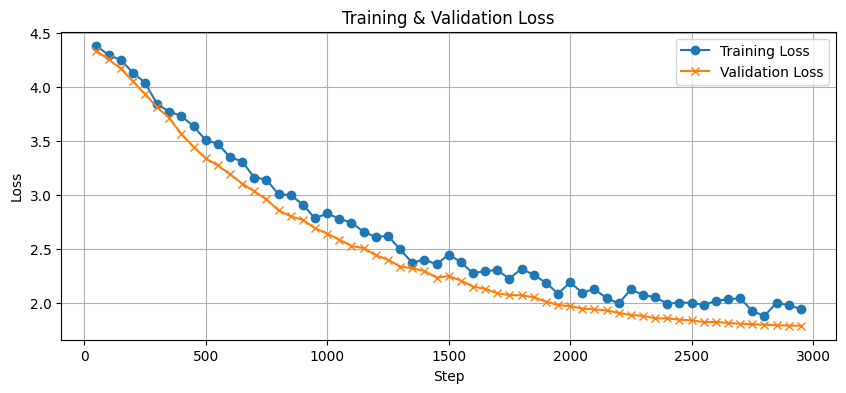

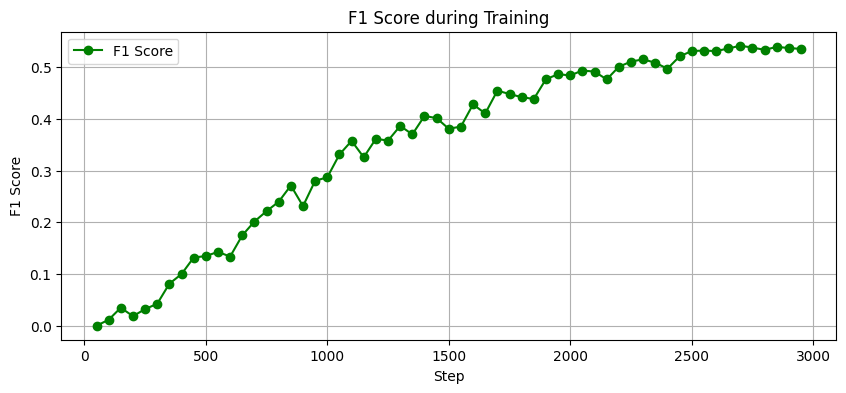

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

train_steps = [x['step'] for x in history if 'loss' in x]
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_steps = [x['step'] for x in history if 'eval_f1' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
eval_loss_steps = [x['step'] for x in history if 'eval_loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(10,4))
plt.plot(train_steps, train_loss, label='Training Loss', marker='o')
plt.plot(eval_loss_steps, eval_loss, label='Validation Loss', marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(eval_steps, eval_f1, label='F1 Score', marker='o', color='green')
plt.xlabel("Step")
plt.ylabel("F1 Score")
plt.title("F1 Score during Training")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
def load_trained_model(model_dir: str):
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    return model, tokenizer

In [55]:
model, tokenizer = load_trained_model("finetuned_model/checkpoint-2950")

## 4. Model Testing

Metrics that will be tested:

- overall accuracy,
- overall precision,
- overall recall,
- overall f1,
- accuracy per class,
- f1 per class

In [59]:
def classify_texts(texts: list[str], model, tokenizer, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()

    return preds


In [60]:
classify_texts(["What is card?"], model, tokenizer)

[38]